In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import string
import nltk    
import matplotlib.pyplot as plt    
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from nltk.corpus import twitter_samples
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn import feature_extraction, linear_model, model_selection, preprocessing

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#text preprocessing
def process_tweet(tweet):
    stemmer=PorterStemmer()
    stopwords_english=stopwords.words('english')
    tweet=re.sub(r'\$\w*','',tweet)
    tweet=re.sub(r'^RT[\s]+','',tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    tweet=re.sub(r'#', '', tweet)
    tokenizer=TweetTokenizer(preserve_case=False,strip_handles=True,reduce_len=True)
    tweet_tokens=tokenizer.tokenize(tweet)
    
    tweets_clean=[]
    for word in tweet_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word=stemmer.stem(word)
            tweets_clean.append(stem_word)
            
    return tweets_clean

Use below function to build the frequency matrix, in the form of ('word',1/0):number of words

In [4]:
def build_freqs(tweets,ys):
    yslist = np.squeeze(ys).tolist()

    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

> **Exploring dataset**

In [5]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv').sample(2000, random_state=10)
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train = train.append(test).drop_duplicates(keep=False)

validation = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

/tmp/ipykernel_20/1335868174.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(test).drop_duplicates(keep=False)


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Data preparation**

In [7]:
train_df1 = list(train[train['target']==1]['text'])
train_df0 = list(train[train['target']==0]['text'])
print(len(train_df1))
print(len(train_df0))

2412
3201


In [8]:
tweets=train_df1+train_df0
print('No of tweets: ',len(tweets))

labels=np.append(np.ones((len(train_df1))),np.zeros((len(train_df0))))

No of tweets:  5613


In [9]:
#create frequency dictionary
freqs=build_freqs(tweets,labels)

**Model preparation**

In [10]:
def sigmoid(z):
    h=1/(1+np.exp(z*(-1)))  
    return h

In [11]:
def gradientDescent(x,y,theta,alpha,num_iters):
    m=len(x)
    for i in range(0,num_iters):
        z=np.dot(x,theta)
        h=sigmoid(z)
        J=((-1)/m)*(np.dot(np.transpose(y),np.log(h))+np.dot(np.transpose(1-y),np.log(1-h)))
        #update the weights theta
        theta=theta-((alpha/m*(np.dot(np.transpose(x),(h-y)))))
    J=float(J)
    return J,theta

**Feature Extraction**

In [12]:
def extract_features(tweet,freqs,process_tweet=process_tweet):
    word_l=process_tweet(tweet)
    x=np.zeros(3)
    x[0]=1
    
    for word in word_l:
        x[1]+=freqs.get((word,1),0)
        x[2]+=freqs.get((word,0),0)
    x=x[None,:]
    assert(x.shape==(1,3))
    return x

In [13]:
train_x=tweets
train_y=pd.DataFrame({'col':labels})

test_x=test['text']
test_y=test['target']

**Define predictive function**

In [14]:
def predict_tweet(tweet,freqs,theta):
    x=extract_features(tweet,freqs)
    y_pred=sigmoid(np.dot(x,theta))
    
    return y_pred

Performance monitor

In [15]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet,thd=0.5):
    y_hat=[]
    for tweet in test_x:
        y_pred=predict_tweet(tweet,freqs,theta)
        if y_pred>thd:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)
            
    accuracy=np.sum(np.array(y_hat)==np.squeeze(test_y))/len(np.array(y_hat))
    return accuracy

In [16]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y

**EDA- Visualize the distribution of the training set**

In [17]:
data_df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

<Axes: >

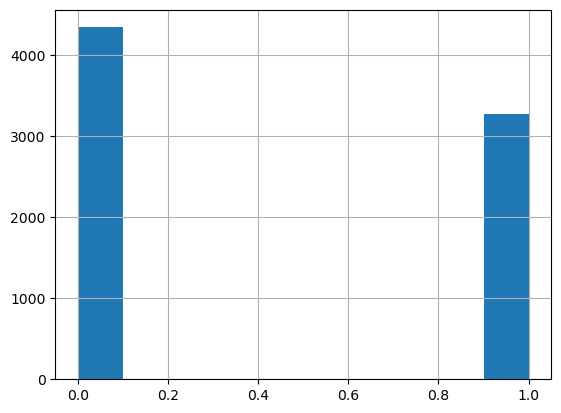

In [18]:
data_df.target.hist()

In [19]:
data_df.location.unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [20]:
data_df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [21]:
rename_map_X = {0:'bias',1:'pos',2:'neg'}
rename_map_Y = {0:'target','col':'target'}

In [22]:
eda_X = pd.DataFrame(X).rename(columns=rename_map_X)
eda_Y = pd.DataFrame(Y).rename(columns=rename_map_Y)
eda_prep = pd.concat([eda_X,eda_Y],axis=1)

In [23]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

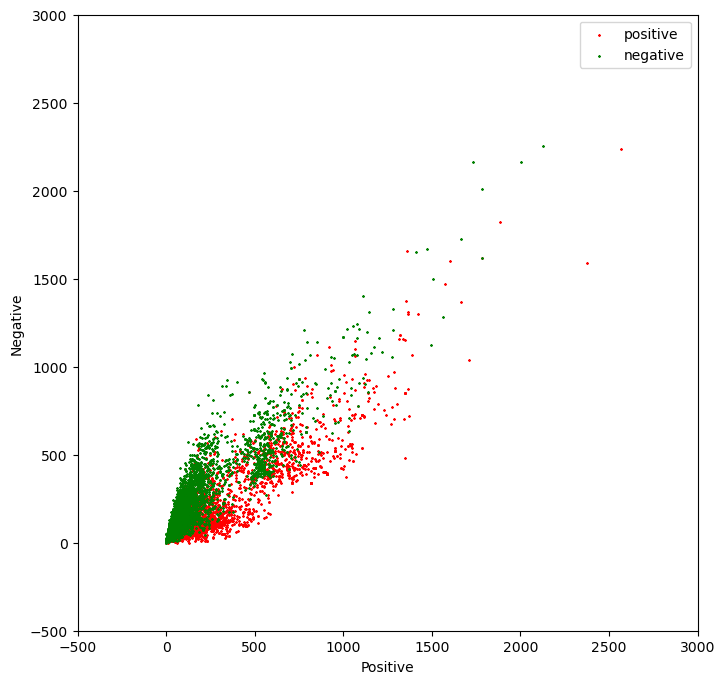

In [24]:
fig, ax= plt.subplots(figsize = (8, 8))
colors = ['green','red'] # Define a color palete
sentiments = ['negative','positive'] 

plt.xlim(-500,3000)  
plt.ylim(-500,3000)

index = eda_prep.index

for sentiment in eda_prep.target.unique():
    ix = index[eda_prep.target == sentiment]
    ax.scatter(x=eda_prep.iloc[ix].pos, y=eda_prep.iloc[ix].neg, c=colors[int(sentiment)], s=1, marker='*', label=sentiments[int(sentiment)])

ax.legend(loc='best')  

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

eda_pos = eda_prep[eda_prep.target == 1]
eda_neg = eda_prep[eda_prep.target == 0]

plt.show()

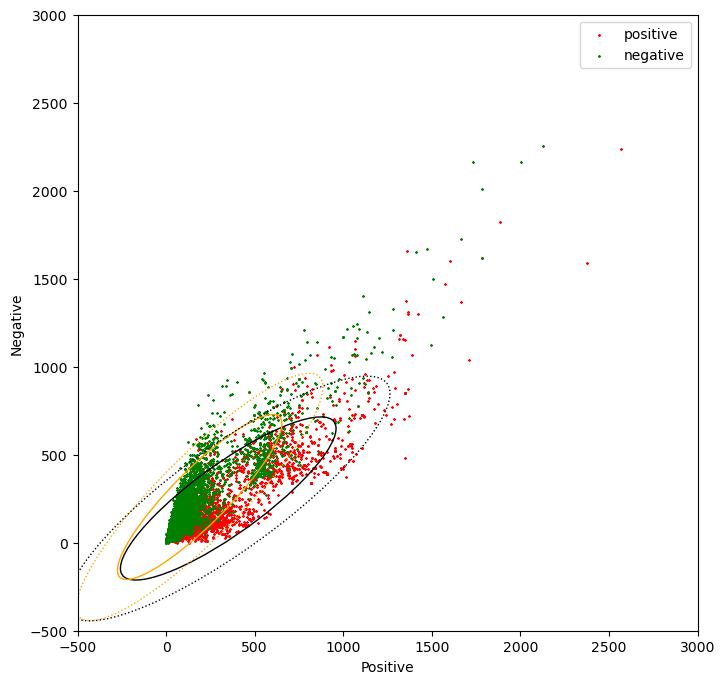

In [25]:
fig, ax= plt.subplots(figsize = (8, 8))
colors = ['green','red'] # Define a color palete
sentiments = ['negative','positive'] 

plt.xlim(-500,3000)  
plt.ylim(-500,3000)

index = eda_prep.index

for sentiment in eda_prep.target.unique():
    ix = index[eda_prep.target == sentiment]
    ax.scatter(x=eda_prep.iloc[ix].pos, y=eda_prep.iloc[ix].neg, c=colors[int(sentiment)], s=1, marker='*', label=sentiments[int(sentiment)])

ax.legend(loc='best')  

plt.xlabel("Positive") # x-axis label
plt.ylabel("Negative") # y-axis label

eda_pos = eda_prep[eda_prep.target == 1]
eda_neg = eda_prep[eda_prep.target == 0]

confidence_ellipse(eda_pos.pos, eda_pos.neg, ax, n_std=2, edgecolor='black', label=r'$2\sigma$' )
confidence_ellipse(eda_neg.pos, eda_neg.neg, ax, n_std=2, edgecolor='orange')

confidence_ellipse(eda_pos.pos, eda_pos.neg, ax, n_std=3, edgecolor='black', linestyle=':', label=r'$3\sigma$')
confidence_ellipse(eda_neg.pos, eda_neg.neg, ax, n_std=3, edgecolor='orange', linestyle=':')

plt.show()

**Training the model**

In [26]:
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-08,6000)

In [27]:
my_tweet = 'Something is happening. I can see the flame from that building!'
print(process_tweet(my_tweet))
y_hat = predict_tweet(my_tweet, freqs, theta)
print(y_hat)
if y_hat > 0.5:
    print('Potential disaster')
else: 
    print('Maybe not a disaster')

['someth', 'happen', 'see', 'flame', 'build']
[[0.49161773]]
Maybe not a disaster


**Making prediction based **